851.9810658009948 0.0
839.1143645624053 16.3265306122449
826.2554847682879 32.6530612244898
813.4044264186431 48.9795918367347
800.5611895134704 65.3061224489796
787.7257740527699 81.63265306122449
774.8981800365418 97.9591836734694
762.078407464786 114.28571428571429
749.2664563375024 130.6122448979592
736.4623266546911 146.9387755102041
723.6660184163521 163.26530612244898
710.8775316224853 179.59183673469389
698.0968662730909 195.9183673469388
685.3240223681687 212.24489795918367
672.5589999077188 228.57142857142858
659.8017988917412 244.89795918367346
647.0524193202359 261.2244897959184
634.3108611932029 277.55102040816325
621.5771245106421 293.8775510204082
608.8512092725535 310.2040816326531
596.1331154789374 326.53061224489795
583.4228431297934 342.8571428571429
570.7203922251217 359.18367346938777
558.0257627649223 375.51020408163265
545.3389547491952 391.8367346938776
532.6599681779405 408.16326530612247
519.9888030511579 424.48979591836735
507.32545936884765 440.8163265306122

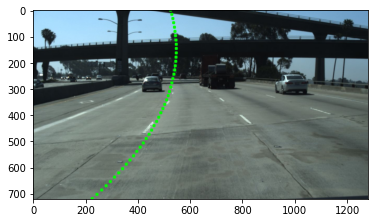

In [7]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.interpolate import splrep, splev, PPoly
#read in data
data_file_path = "/home/automan/wuguanjie/TuSimple/train/label_data_0313.json"
with open(data_file_path,"r") as f:
    data = f.readlines()
count = 0
for line in data:
    dict = json.loads(line)
    
    x_coor = dict["lanes"]
    y_coor = dict["h_samples"]
    im_path = dict["raw_file"]
    im_path = os.path.join("/home/automan/wuguanjie/TuSimple/train", im_path)
    
    #zip the coordinates
    coor_list = [list(zip(i, y_coor)) for i in x_coor]

    #filter out -2
    filtered_coor_list = []
    for i in coor_list:
        tmp = []
        for j in i:
            if j[0] < 0:
                continue
            tmp.append(j)
        filtered_coor_list.append(tmp)
    
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # for i in filtered_coor_list:
    #     for (x,y) in i:
            # cv2.circle(im, (x,y), 1,(255,0,0), 10)

    #apply polyfit
    for i in filtered_coor_list:
        if len(i) == 0:
            continue
        filtered_x_coor , filtered_y_coor = zip(*i)
        new_series = poly.polyfit(filtered_y_coor[-3:], filtered_x_coor[-3:], deg = 1)
        y_extrapolated = np.arange(filtered_y_coor[-1], filtered_y_coor[-1]+ 10*10, 10)
        x_extrapolated = poly.polyval(y_extrapolated, new_series)

        #############################################


        ############################################
        filtered_y_coor = np.array(filtered_y_coor)
        filtered_x_coor = np.array(filtered_x_coor)
        for i in x_extrapolated:
            filtered_x_coor = np.append(filtered_x_coor, i)
        for j in y_extrapolated:
            filtered_y_coor = np.append(filtered_y_coor,j)

        weights = np.ones(len(filtered_x_coor))
        weights[:5] = 10
        # weights[-2:] = 5
        new_series = poly.polyfit(filtered_y_coor, filtered_x_coor, deg = 2, w = weights)
        y_line = np.linspace(0, 800, 50)
        x_line = poly.polyval(y_line, new_series)

        # tck = splrep(filtered_y_coor, filtered_x_coor, k=3)
        # F = PPoly.from_spline(tck)
        # print(tck)
        # x_line = splev(y_line, spline)


        
        lane = [(xcord, ycord) for (xcord, ycord) in zip(x_line, y_line)]
        for x, y in lane:
            print(x,y)
            cv2.circle(im, (int(x),int(y)), 1,(0,255,0), 10)
        plt.imshow(im)
        break
    count += 1
    cv2.imwrite("/home/automan/wuguanjie/SCNN_Pytorch/rubbish_bin/tmp.jpg", im)
    if count == 5:
        break


#plot onto the image for verification